In [1]:
from cortexlib.mouse import CortexlabMouse

mouse = CortexlabMouse()

null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

In [2]:
from cortexlib.images import CortexlabImages

images = CortexlabImages()
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)

In [3]:
from cortexlib.simclr import PreTrainedSimCLRModel

simclr = PreTrainedSimCLRModel()
simclr_features, _ = simclr.extract_features(image_dataset)

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


  0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
from cortexlib.predictor import NeuralResponsePredictor

results = []

for layer, feats in simclr_features.items():
    predictor = NeuralResponsePredictor()
    r_squared = predictor.compute_r_squared(feats, neural_responses)
    fev = predictor.compute_fev(feats, neural_responses)
    
    results.append({
        'layer': layer,
        'test_r2': r_squared['test_r2'],
        'mean_fev': fev['mean_fev']
    })

In [5]:
from cortexlib.utils.file import write_json_file

write_json_file(results, f'./results/simclr_feats_to_neural_data.json')

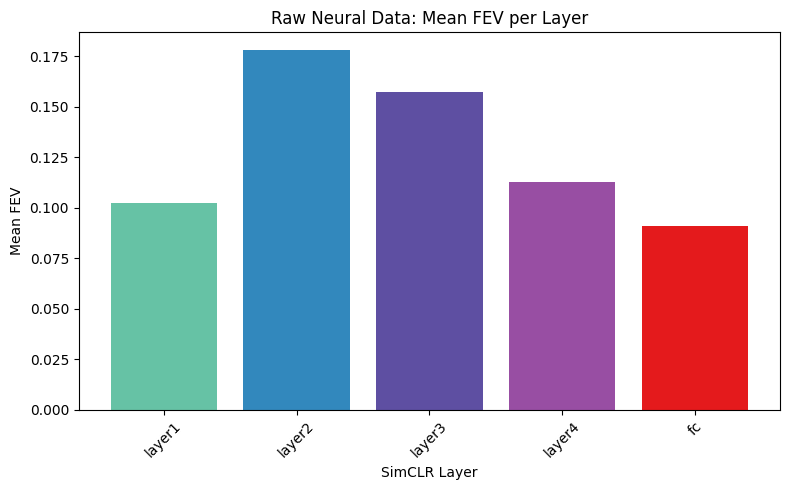

In [6]:
import matplotlib.pyplot as plt
from cortexlib.utils.plotting import simclr_colors

layers = [r['layer'] for r in results]
mean_fevs = [r['mean_fev'] for r in results]

colors = [simclr_colors[layer] for layer in layers]

plt.figure(figsize=(8, 5))
plt.bar(layers, mean_fevs, color=colors)
plt.ylabel("Mean FEV")
plt.xlabel("SimCLR Layer")
plt.title("Raw Neural Data: Mean FEV per Layer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()